In [ ]:
import torch
import my_nlp_library as nlp
import torch
import torch.optim as optim
import torch.nn as nn
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
# Load the GloVe vectors
def load_glove_vectors(glove_file):
    glove_vectors = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = torch.tensor([float(val) for val in values[1:]], dtype=torch.float32)
            glove_vectors[word] = vector
    return glove_vectors

glove_file = "glove.6B/glove.6B.300d.txt"  # Change this to the appropriate file if needed
glove_vectors = load_glove_vectors(glove_file)


def get_vocabulary_from_glove(glove_vectors):
    vocab = dict()
    inverse_vocab = list()
    vocab["<PAD>"] = 0
    inverse_vocab.append("<PAD>")
    vocab["<UNK>"] = 1
    inverse_vocab.append("<UNK>")
    for word, vector in glove_vectors.items():
        vocab[word] = len(inverse_vocab)
        inverse_vocab.append(word)
    return vocab, inverse_vocab

vocab, inverse_vocab = get_vocabulary_from_glove(glove_vectors)

In [3]:
embedding_dim = 300  # This should match the dimension of the GloVe vectors
vocab_size = len(glove_vectors) + 2
embedding = nn.Embedding(vocab_size, embedding_dim)

for idx, word in enumerate(inverse_vocab[2:]):
    i = idx + 2
    embedding.weight[idx].data = glove_vectors[word]

print("Embedding layer created with shape:", embedding.weight.shape)

Embedding layer created with shape: torch.Size([400002, 300])


In [ ]:
embedding_2000 = embedding.weight.data[:2000]  # estou pegando somente as primeiras 1000 palavras

X = embedding_2000.numpy()

tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(X)



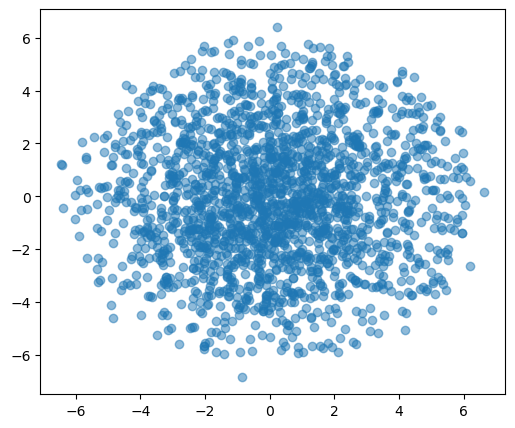

In [14]:
plt.figure(figsize=(6, 5))
vocab_to_plot = 2000
plt.scatter(X_2d[:vocab_to_plot, 0], X_2d[:vocab_to_plot, 1], alpha=0.5)

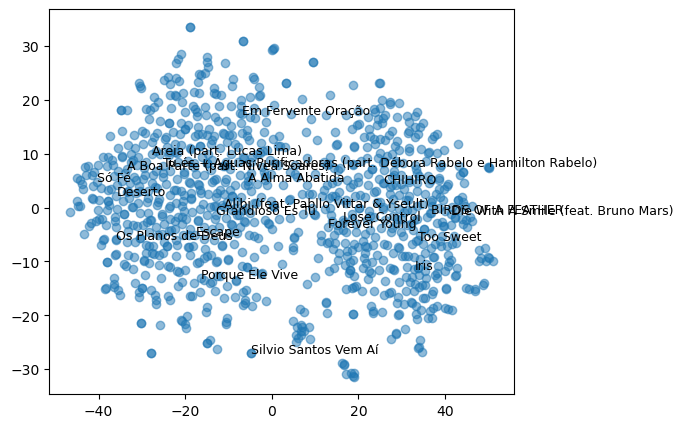

In [26]:
import re

def get_vocabulary(text : str,
                   expr: str=r"\b\w+\b",
                   case_sensitive : bool=False,
                   ) -> dict:
    if case_sensitive == False:
        text = text.lower()  
    vocabulary = set(re.findall(expr, text))
    vocab = dict()
    inverse_vocab = list()
    vocab["<PAD>"] = 0
    inverse_vocab.append("<PAD>")
    vocab["<UNK>"] = 1
    inverse_vocab.append("<UNK>")
    for i, token in enumerate(vocabulary):
        if token not in vocab:
            vocab[token] = i+2 # We start from 2 because 0 and 1 are reserved for <UNK> and <PAD>
            inverse_vocab.append(token)
    return vocab, inverse_vocab

def tokenize_words(text : str,
             vocab : dict,
             expr : str= r"\b\w+\b",
             sentence_length : int = 10,
             case_sensitive : bool = False) -> list:
    if case_sensitive == False:
        text = text.lower()
    words = re.findall(expr, text)
    tokens = []
    for i, w in enumerate(words):
        if i == sentence_length:
            break
        if w in vocab:
            tokens.append(vocab[w])
        else:
            tokens.append(vocab["<UNK>"])


    if len(tokens) < sentence_length:
        n_pad = sentence_length - len(tokens)
        pad = [vocab["<PAD>"]] * n_pad
        tokens = pad + tokens
    return tokens

def detokenize_words(tokens : list,
                    invert_vocab : list) -> str:
    text = " ".join([invert_vocab[token] for token in tokens])
    return text    

class MyTokenizer:
    def __init__(self, sentence_length, case_sensitive=False, vocab=None, inverse_vocab=None):
        self.sentence_length = sentence_length
        self.case_sensitive = case_sensitive
        self.vocab = vocab
        self.inverse_vocab = inverse_vocab
        if vocab is not None:
            self.vocab_size = len(vocab)

    def fit(self, phrases : list, expr : str=r"\b\w+\b"):
        self.vocab, self.inverse_vocab = get_vocabulary(" ".join(phrases),
                                                        expr=expr,
                                                        case_sensitive=self.case_sensitive)
        self.vocab_size = len(self.vocab)
        
    def __call__(self, x):
        return tokenize_words(x,
                              self.vocab,
                              sentence_length=self.sentence_length,
                              case_sensitive=self.case_sensitive)
    



df = pd.read_csv('data/musicas.csv', delimiter='|')

'''
| Titulo-Artista | Letra |
| Die With A Smile (feat. Bruno Mars)-Lady Gaga |	Ooh\nI I just woke up from a dream\nWhere you... |
| ... | ... |
'''

# vamos tokenizar as letras com nlp.tokenize_words e depois vamos pegar os embeddings de cada palavra

# tokenizar as letras
tokenizer = MyTokenizer(sentence_length=10, case_sensitive=False, vocab=None, inverse_vocab=None)
tokenizer.fit(df['Letra'])
df['Tokens'] = df['Letra'].apply(tokenizer)

# pegar os embeddings de cada palavra
embeddings = []
for tokens in df['Tokens']:
    embeddings.append(embedding(torch.tensor(tokens)).mean(dim=0).detach().numpy())
    
embeddings = torch.tensor(embeddings)

# vamos fazer o tsne
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(6, 5))
plt.scatter(X_2d[:, 0], X_2d[:, 1], alpha=0.5)

# vamos fazer escrever no grafico o nome de algumas musicas
n = 20

for i in range(n):
    plt.text(X_2d[i, 0], X_2d[i, 1], df['Titulo-Artista'][i].split("-")[0], fontsize=9)
    
plt.show()


Podemos perceber 2 grupos no gráfico do tsne. Isso se dá por conta das duas línguas presentes no dataset, inglês e português. Quando um plt.text é feito, fica muito clara a separação entre as duas línguas.

Epoch 0, Loss 0.14714179933071136
Epoch 100, Loss 0.002739756368100643
Epoch 200, Loss 0.000129960200865753
Epoch 300, Loss 1.6792544101917883e-06
Epoch 400, Loss 4.063170688795026e-09
Epoch 500, Loss 3.778186530994931e-12
Epoch 600, Loss 1.5330618718945033e-14
Epoch 700, Loss 9.416139166941364e-15
Epoch 800, Loss 8.623644130061926e-15
Epoch 900, Loss 8.495538020086239e-15


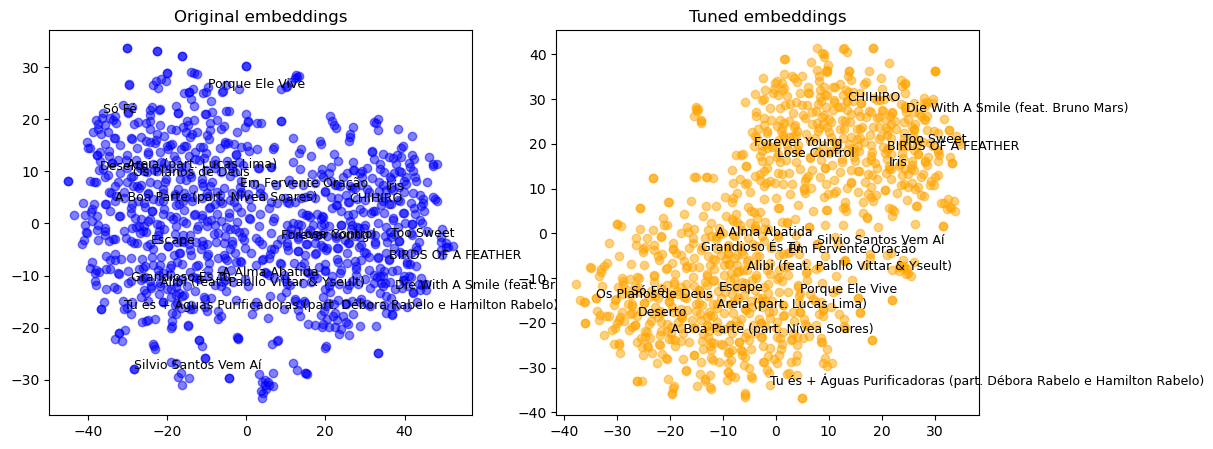

In [41]:

class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        xenc = self.encoder(x)
        x = self.decoder(xenc)
        return x, xenc
    
input_size = embedding_dim
hidden_size = 500
autoencoder = Autoencoder(input_size, hidden_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

X = embeddings

n_epochs = 1000
for epoch in range(n_epochs):
    optimizer.zero_grad()
    output, _ = autoencoder(X)
    loss = criterion(output, X)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss {loss.item()}')
        
_, encoded = autoencoder(X)
encoded = encoded.detach().numpy()

tsne = TSNE(n_components=2, random_state=0)
X_2d_tuned = tsne.fit_transform(encoded)

n = 20

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_2d[:, 0], X_2d[:, 1], alpha=0.5, color='blue')
plt.title("Original embeddings")

for i in range(n):
    plt.text(X_2d[i, 0], X_2d[i, 1], df['Titulo-Artista'][i].split("-")[0], fontsize=9)

plt.subplot(1, 2, 2)
plt.scatter(X_2d_tuned[:, 0], X_2d_tuned[:, 1], alpha=0.5, color='orange')
plt.title("Tuned embeddings")

for i in range(n):
    plt.text(X_2d_tuned[i, 0], X_2d_tuned[i, 1], df['Titulo-Artista'][i].split("-")[0], fontsize=9)

plt.show()

# analisando os gráficos:
# os embeddings originais parecem estar um pouco mais espalhados, enquanto os embeddings ajustados parecem estar mais clusterizados. Isso sugere que o autoencoder está 
# separando os embeddings em grupos mais coesos (nesse caso o idioma das músicas). Isso é um bom sinal, pois sugere que o autoencoder está aprendendo a representação
# das músicas de forma mais compacta e informativa.

In [73]:
# Inicialize o tokenizer e ajuste-o ao vocabulário das letras no df
tokenizer = MyTokenizer(sentence_length=10, case_sensitive=False)
tokenizer.fit(df['Letra'].tolist())

# Tokenize cada letra no DataFrame e armazene os tokens
df['Tokens'] = df['Letra'].apply(lambda x: tokenizer(x))


In [74]:
import torch

# Definindo a função que calcula o embedding médio
def get_average_embedding(tokens, embedding):
    # Converte tokens em embeddings e calcula a média
    embeddings = torch.stack([embedding(torch.tensor([token])) for token in tokens if token != tokenizer.vocab["<PAD>"]])
    return torch.mean(embeddings, dim=0) if embeddings.shape[0] > 0 else torch.zeros(embedding.embedding_dim)

# Aplica a função de embedding médio a cada letra
df['Embedding'] = df['Tokens'].apply(lambda tokens: get_average_embedding(tokens, embedding))


In [112]:
import json

def get_closest_song(lyrics, embedding, tokenizer, threshold=0.5, n=10):
    # Tokeniza e calcula o embedding médio da letra buscada
    tokens = tokenizer(lyrics)
    lyrics_embedding = get_average_embedding(tokens, embedding)
    
    # Calcula a distância entre o embedding da letra e o embedding médio de cada letra no dataset
    distances = [(i, torch.dist(lyrics_embedding, row_embedding).item()) for i, row_embedding in enumerate(df['Embedding'])]
    
    # Filtra as músicas que estão dentro do threshold e ordena pela menor distância
    within_threshold = [d for d in distances if d[1] <= threshold]
    closest = sorted(within_threshold, key=lambda x: x[1])[:n]
    
    # Retorna os títulos, letras e distâncias em um formato específico
    results = [
        {
            "title": df.iloc[c[0]]['Titulo-Artista'],
            "content": df.iloc[c[0]]['Letra'],
            "relevance": c[1]
        }
        for c in closest
    ]
    
    # Formata o resultado em JSON com indentação
    print("Músicas encontradas:", len(results))
    print(json.dumps(results, indent=4, ensure_ascii=False))

# Testes da busca com threshold e visualização das distâncias
print("Teste 1:")
get_closest_song("Don't feel like picking up my phone So leave a message at the tone", embedding, tokenizer, threshold=7)
print("\n")




Teste 1:
Músicas encontradas: 10
[
    {
        "title": "Under The Bridge-Red Hot Chili Peppers",
        "content": "Sometimes I feel like\nI don't have a partner\nSometimes I feel like\nMy only friend\nIs the city I live in\nThe city of angels\nLonely as I am\nTogether we cry I drive on her streets, 'cause\nShe's my companion\nI walk through her hills, 'cause\nShe knows who I am\nShe sees my good deeds and\nShe kisses me windy\nAnd I never worry\nNow that is a lie I don't ever wanna feel\nLike I did that day\nBut take me to the place I love\nTake me all the way\nI don't ever wanna feel\nLike I did that day\nBut take me to the place I love\nTake me all the way It's hard to believe that\nThere's nobody out there\nIt's hard to believe\nThat I'm all alone\nAt least I have her love\nThe city, she loves me\nLonely as I am\nTogether we cry I don't ever wanna feel\nLike I did that day\nBut take me to the place I love\nTake me all the way\nI don't ever wanna feel\nLike I did that day\nBut t

In [113]:
print("Teste 2:")
get_closest_song("Burnin in your eyes", embedding, tokenizer, threshold=7)
print("\n")


Teste 2:
Músicas encontradas: 1
[
    {
        "title": "Always Remember Us This Way-Lady Gaga",
        "content": "That Arizona sky\nBurnin' in your eyes\nYou look at me and, babe, I wanna catch on fire\nIt's buried in my soul\nLike California gold\nYou found the light in me that I couldn't find So when I'm all choked up but I can't find the words\nEvery time we say goodbye, baby, it hurts\nWhen the sun goes down\nAnd the band won't play\nI'll always remember us this way Lovers in the night\nPoets tryin' to write\nWe don't know how to rhyme but, damn, we try\nBut all I really know\nYou're where I wanna go\nThe part of me that's you will never die So when I'm all choked up and I can't find the words\nEvery time we say goodbye, baby, it hurts\nWhen the sun goes down\nAnd the band won't play\nI'll always remember us this way Oh, yeah\nI don't wanna be just a memory, baby, yeah Oh, oh, oh So when I'm all choked up and I can't find the words\nEvery time we say goodbye, baby, it hurts\nWh

In [ ]:
print("Teste 3:")


# nesse teste 3, preciso fazer uma resposta nao obvia. 

Teste 3:
Músicas encontradas: 0
[]


In [133]:
import json

def get_closest_song(lyrics, embedding, tokenizer, autoencoder, use_tuned=True, threshold=0.5, n=10):
    # Tokeniza e calcula o embedding médio da letra buscada
    tokens = tokenizer(lyrics)
    lyrics_embedding = get_average_embedding(tokens, embedding)
    
    if use_tuned:
        # Passar pelo autoencoder para obter o embedding tunado
        _, lyrics_embedding = autoencoder(lyrics_embedding.unsqueeze(0))
        lyrics_embedding = lyrics_embedding.squeeze(0)
    
    # Calcula a distância entre o embedding da letra e o embedding médio de cada letra no dataset
    distances = []
    for i, row_embedding in enumerate(df['Embedding']):
        if use_tuned:
            _, row_embedding = autoencoder(row_embedding.unsqueeze(0))
            row_embedding = row_embedding.squeeze(0)
        distance = torch.dist(lyrics_embedding, row_embedding).item()
        distances.append((i, distance))
    
    # Filtra as músicas que estão dentro do threshold e ordena pela menor distância
    within_threshold = [d for d in distances if d[1] <= threshold]
    closest = sorted(within_threshold, key=lambda x: x[1])[:n]
    
    # Retorna os títulos, letras e distâncias em um formato específico
    results = [
        {
            "title": df.iloc[c[0]]['Titulo-Artista'],
            "content": df.iloc[c[0]]['Letra'],
            "relevance": c[1]
        }
        for c in closest
    ]
    
    # Formata o resultado em JSON com indentação
    print("Músicas encontradas:", len(results))
    print(json.dumps(results, indent=4, ensure_ascii=False))

# Testes da busca com threshold e visualização das distâncias
print("Teste com embeddings tunados:")
get_closest_song("Burning in your eyes", embedding, tokenizer, autoencoder, use_tuned=True, threshold=8.2)
print("\n")

print("Teste com embeddings não tunados:")
get_closest_song("Burning in your eyes", embedding, tokenizer, autoencoder, use_tuned=False, threshold=8)
print("\n")

Teste com embeddings tunados:
Músicas encontradas: 1
[
    {
        "title": "Always Remember Us This Way-Lady Gaga",
        "content": "That Arizona sky\nBurnin' in your eyes\nYou look at me and, babe, I wanna catch on fire\nIt's buried in my soul\nLike California gold\nYou found the light in me that I couldn't find So when I'm all choked up but I can't find the words\nEvery time we say goodbye, baby, it hurts\nWhen the sun goes down\nAnd the band won't play\nI'll always remember us this way Lovers in the night\nPoets tryin' to write\nWe don't know how to rhyme but, damn, we try\nBut all I really know\nYou're where I wanna go\nThe part of me that's you will never die So when I'm all choked up and I can't find the words\nEvery time we say goodbye, baby, it hurts\nWhen the sun goes down\nAnd the band won't play\nI'll always remember us this way Oh, yeah\nI don't wanna be just a memory, baby, yeah Oh, oh, oh So when I'm all choked up and I can't find the words\nEvery time we say goodby